# Day 3

Modelling plant gas-exchange process

<div class="alert alert-warning">
If figures/tables are not rendered correctly, make sure your notebook is `trusted` by choosing `Trust Notebook` command found in `View` - `Activate Command Palette` menu. Typing in the first letters (i.e. "tr") should give you the command.
</div>

In [1]:
using Cropbox

We will use interactive plotting feature in this notebook. For this, we have to initialize [WebIO.jl](https://github.com/JuliaGizmos/WebIO.jl) manually when using [prebuilt system images](https://github.com/JuliaLang/PackageCompiler.jl) as we do with our JupyterHub environment.

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

Bisection method used for optimization by default prints out warning messages when it can't find a solution within a given range, for example, when we try running simulation under an extreme condition (*i.e.* some zero values for parameters). Let's make it quiet.

In [3]:
using Logging
Logging.disable_logging(Logging.Warn)

LogLevel(1001)

## 1. Leaf gas-exchange model

The leaf gas-exchange model was originally derived from [Kim and Lieth (2003)](https://doi.org/10.1093/aob/mcg080) with an addition of C4 photosynthesis and stress responses based on [MAIZSIM](https://github.com/ARS-CSGCL-DT/MAIZSIM). The model was reimplemented in the Cropbox framework to build a garlic model [Garlic.jl](https://github.com/cropbox/Garlic.jl). 

A standalone package for couple leaf gas-exchange model is available as [LeafGasExchange.jl](https://github.com/cropbox/LeafGasExchange.jl). Description of the standalone gas-exchange model is available from [Yun et al. (2020)](https://doi.org/10.3390/plants9101358) with applications focusing on C4 leaves. We will use this standalong package to study leaf gas-exchange behavior without going into the model details. If yor're intersted in the internals of how the model was put together, pleaes refer to the optional notebook on its implementation placed in the same folder.

In [4]:
using LeafGasExchange

#### $\mathrm{CO_2}$ diffusion equation: The supply function

$$
A = \frac{g_{t}}{1.6} (C_a - C_i) \simeq \frac{g_{s}}{1.6} (C_a - C_i)
$$

In order for $\mathrm{CO_2}$ assimilation to take place at the cholorplast, the biochemical demand for $\mathrm{CO_2}$ to run the photosynthetic machinery (the Calvin cycle) must be met by the supply of $\mathrm{CO_2}$ (substrate) from the atmosphere. To reach the site of caboxylation at the choloroplast, $\mathrm{CO_2}$ molecules need to travel through the leaf boundary layer, stomatal pores, interceullar airspaces, and mesophyll cell walls before dissolving into the liquid phase to enter the Calvin cycle inside the leaf. Each of these steps exert resistence in the diffusional pathway. To account for this, we use conductance terms which are the reciprocal of the resistence terms: $g_b$ for boudary later conductance, $g_s$ for stomatal conductance, and $g_m$ for mesophyll conductance that lumps all internal conductances (i.e., intercellular spaces, cell wall, and liquid phase)together. 

$$
\frac{1}{g_t} = \frac{1}{g_b} + \frac{1}{g_s} + \frac{1}{g_m} \approx \frac{1}{g_b} + \frac{1}{g_s}
$$

All conductance terms are for water vapor ($\mathrm{H_2O}$). $g_t$ is the total conductance that combines all counductances. Here, an important assumption we make is that the mesophyll conductance is infinite (that is, no internal resistence between sub-stomatal cavity and the chloroplast once $\mathrm{CO_2}$ enters a stoma. This means we assume $C_i$ $\simeq$ $C_c$. The total conductance for $\mathrm{H_2O}$ is divided by 1.6 here to account for the slow diffusion of $\mathrm{CO_2}$ due to heavier molecular weight. If $g_b$ is sufficiently large, we may also assume: $g_t$ $\approx$ $g_s$.

#### Biochemical model of C3 photosynthesis (FvCB): The demand function

$$
A = \min \{ A_c, A_j, A_p \}
$$

$$
A_c = V_{c\!\max} \frac{C_i - \Gamma^*}{C_i + K_c \cdot (1 + {O_i}/{K_o})} - R_d
$$

$$
A_j = \frac{J \cdot (C_i - \Gamma^*)}{4 (C_i + 2 \Gamma^*)} - R_d
$$

$$
A_p = 3T_p - R_d
$$

#### Stomatal conductance model (Ball-Berry): The coupler

$$
g_s = g_0 + g_1 \frac{h_s A}{C_s}
$$

#### Model parameters and variables
| Symbol | Units | Description |
|:-------|:------|:------------|
|| **The FvCB C3 photosynthesis model** ||
| $A$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Net $\mathrm{CO_2}$ assimilation rate |
| $A_c$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Rubisco-limited $\mathrm{CO_2}$ assimilation rate |
| $A_j$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Electron transport-limited $\mathrm{CO_2}$ assimilation rate |
| $A_p$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Triose phosphate utilization-limited $\mathrm{CO_2}$ assimilation rate |
| $C_a$ | $\mathrm{\mu bar}$ | Atmospheric $\mathrm{CO_2}$ partial pressure |
| $C_i$ | $\mathrm{\mu bar}$ | Intercellular $\mathrm{CO_2}$ partial pressure |
| $\Gamma^*$ | $\mathrm{\mu bar}$ | $\mathrm{CO_2}$ compensation point when $A$ = 0 and $R_d$ = 0|
| $J$ | $\mathrm{\mu mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Electron transport rate |
| $J_{\max}$ | $\mathrm{\mu mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of electron transport |
| $K_c$ | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ |
| $K_o$ | $\mathrm{mbar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{O_2}$ |
| $R_d$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Mitochondrial respiration rate |
| $O_i$ | $\mathrm{mbar}$ | Intercellular $\mathrm{O_2}$ partial pressure |
| $T_p$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of triose phosphate utilization |
| $V_{c\!\max}$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of Rubisco carboxylation |
|| **The Ball-Berry Stomatal Counductance Model** ||
| $g_s$ | $\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Stomatal conductance for water vapor |
| $g_t$ | $\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Total conductance for water vapor in the diffusion pathway |
| $g_0$ | $\mathrm{mol_{H_2O}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Minimal stomatal conductance $\mathrm{CO_2}$ due to cuticular and residual water loss (also known as $b$ parameter |
| $g_1$ | - | Empirical parameter related to stomatal sensitivity to the marginal water cost of carbon gain (also know as $m$ parameter)  |
| $h_s$ | - | Relative humidity at the leaf surface as fraction |

`LeafGasExchange.jl` package implements gas-exchange model for C3 and C4 leaves. Two types of stomatal conductance models, Ball-Berry (BB) and Medlyn (MD) are supported. For example, `ModelC3BB` indicates leaf-level gas-exchange model for C3 leaf coupled with Ball-Berry model.

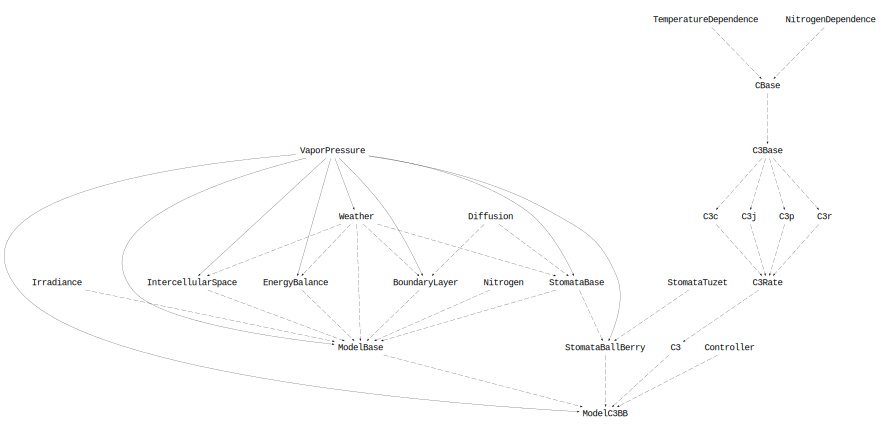

In [5]:
Cropbox.hierarchy(ModelC3BB; skipcontext = true)

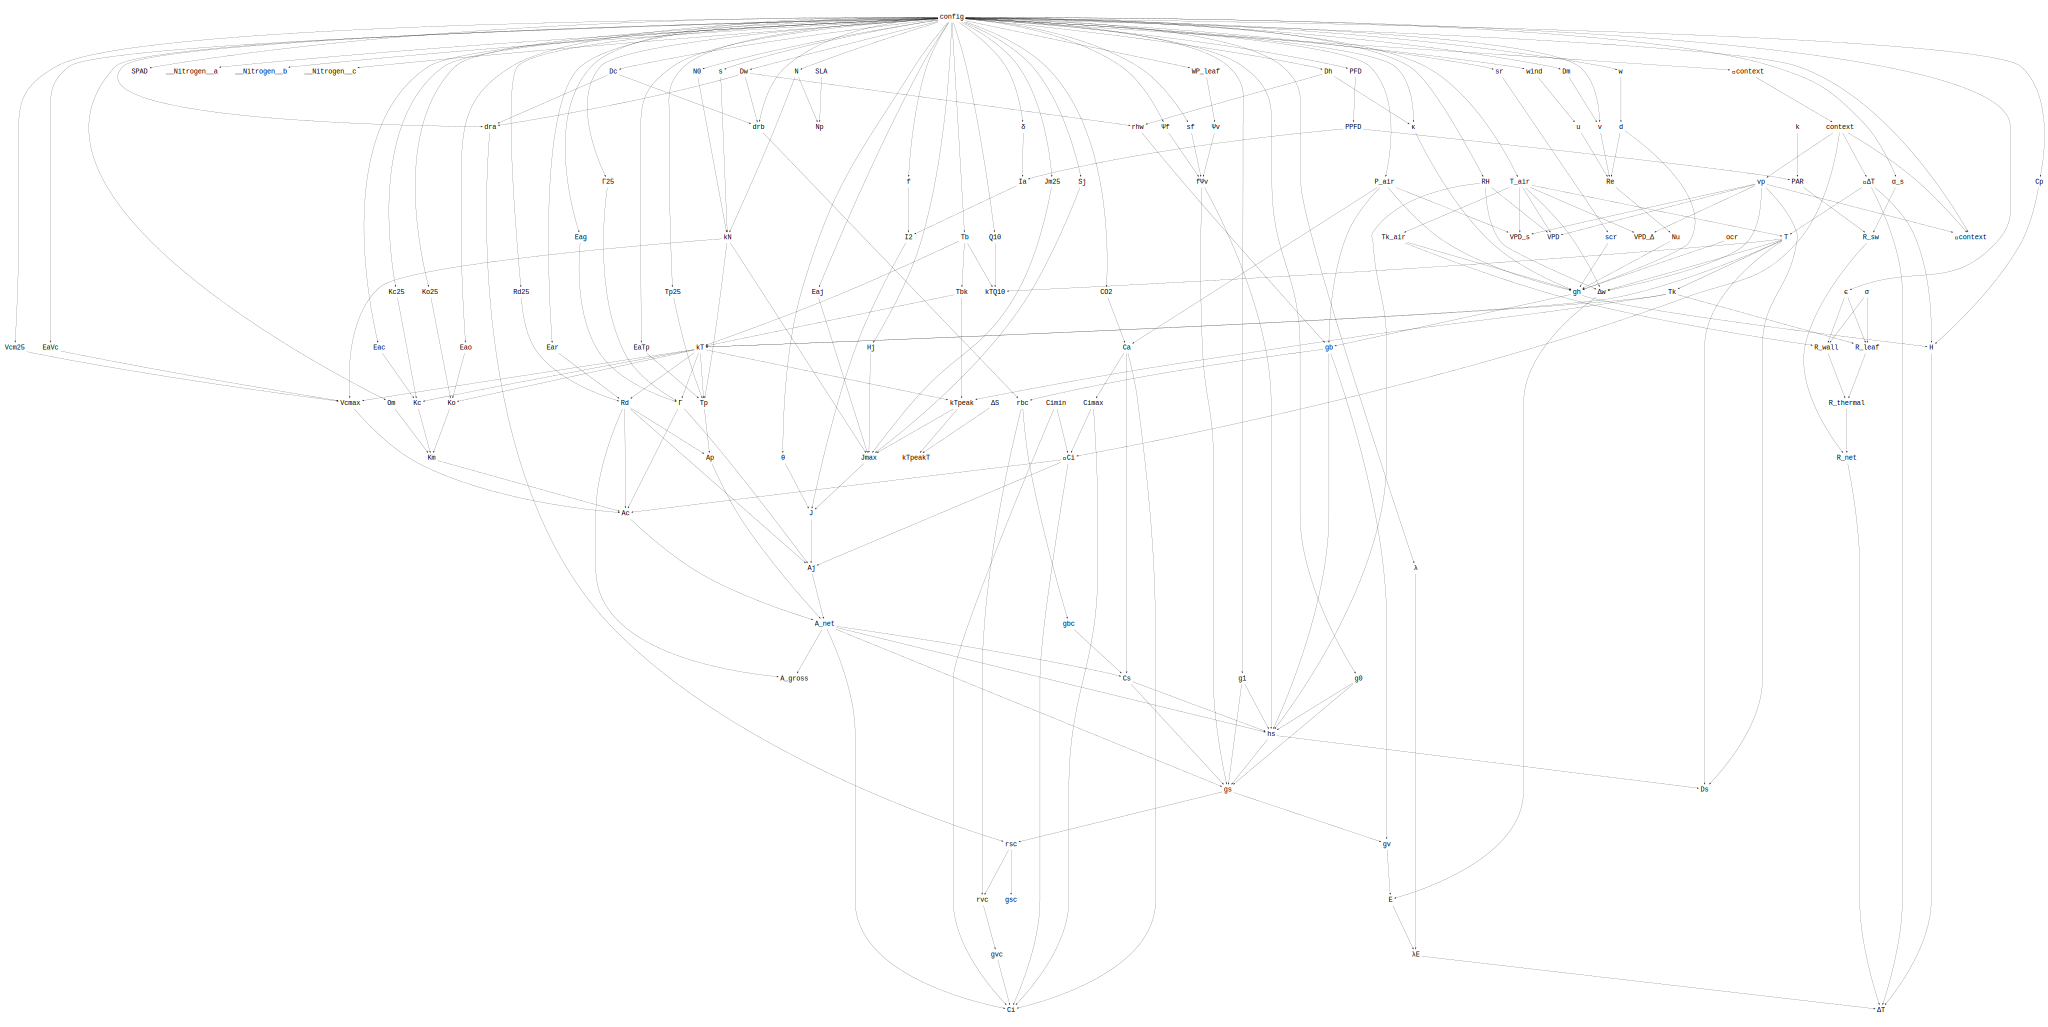

In [6]:
Cropbox.dependency(ModelC3BB)

## 2. Exercises

#### Ex 3.1

Use Cropbox to examine how photosynthesis, stomatal conductance, and transpiration at the leaf level will respond to light (PFD; photosynthetic photon flux density), $\mathrm{CO_2}$ in the air, air temperature (Air T), relative humidity (RH), and soil or leaf water potential (SWP or WP_leaf) with default leaf traits for rose and maize. Evaluate and discuss the results. How are they similar or different? Do model predictions make sense to you? Discuss why or why not.

To answer these questions, we first need to check the deafult parameter values for C3 photosynthesis and Ball-Berry stomatal conductatance models implemented in LeafGasExchange package, and make a new instance for species of interest. We will focus on rose, a C3 plant. The same approach method can apply for maize which is a C4 plant.

In [7]:
c1 = parameters(LeafGasExchange.ModelC3BB);

From [Kim and Lieth (2003)](https://doi.org/10.1093/aob/mcg080), we see that some of the FcVB and Ball-Berry model parameter values for rose leaves are different than the default values. We will create a new parameter configuration for a rose leaf and update their parameter values as described in [Kim and Lieth (2003)](https://doi.org/10.1093/aob/mcg080). The current version of LeafGasExchange package rquires optimal temperature for J (Toj). Toj can be obtained from the function below based on Sj, Eaj (or Haj), and Hj (or Hdj).

Create a gas-exchange configuration for rose leaf. We will use a generic g0 and g1 values for C3 leaves instead of the values calibrated for rose leaves (0.096, 10.055).

In [8]:
ge_rose = @config (
    :C3 => (
        Vcm25 = 102.4, Jm25 = 162.0, Tp25 = 11.55, Rd25 = 1.260,
        Kc25 = 404, Ko25 = 248, Eac = 59.4, Eao = 36.0, Ear = 66.4, EaVc = 45.5,
        Eaj = 43.3, Hj = 219.4, Sj = 704.2, Γ25 = 36.9,
    ),
    :StomataBallBerry => (
        g0 = 0.03,
        g1 = 10.0
    ),
    :Weather => (
        PFD = 1500,
        CO2 = 400,
        RH = 60,
        T_air = 25,
        wind = 2.0,
    )
);

Generate CO2 response curves (aka A-Ci curve) for all three limiting steps.

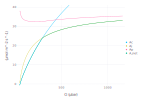

In [9]:
visualize(LeafGasExchange.ModelC3BB, :Ci, [:Ac, :Aj, :Ap, :A_net];
    config = ge_rose,
    xstep = :Weather => :CO2 => 10:10:1500,
    ylim = (0,40),
    kind = :line,
)

Generate light response curves (aka A-Q curve) for all three limiting steps.

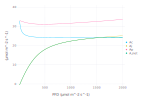

In [10]:
visualize(LeafGasExchange.ModelC3BB, :PFD, [:Ac, :Aj, :Ap, :A_net];
    config = ge_rose,
    xstep = :Weather => :PFD => 10:10:2000,
    ylim = (0,40),
    kind = :line,
)

Generate temperature response curves of A and its three limiting steps.

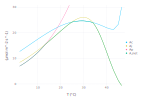

In [11]:
visualize(LeafGasExchange.ModelC3BB, :T, [:Ac, :Aj, :Ap, :A_net];
    config = ge_rose,
    xstep = :Weather => :T_air => 0:1:45,
    ylim = (0,30),
    kind = :line,
)

Generate relative humidity response curves of A and its three limiting steps.

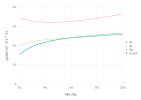

In [12]:
visualize(LeafGasExchange.ModelC3BB, :RH, [:Ac, :Aj, :Ap, :A_net];
    config = ge_rose,
    xstep = :Weather => :RH => 20:5:100,
    ylim = (0,40),
    kind = :line,
)

Generate leaf water potential response curves of A and its three limiting steps.

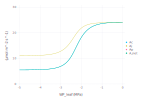

In [13]:
visualize(LeafGasExchange.ModelC3BB, :WP_leaf, [:Ac, :Aj, :Ap, :A_net];
    config = ge_rose,
    xstep = :StomataTuzet => :WP_leaf => -5:0.02:0,
    ylim = (0,30),
    kind = :line,
)

#### Ex 3.2

Based on the coupled models of C3 and C4 leaves, generate $A/C_i$ and light response ($A/Q$) curves for C3 (rose) and C4 (maize) leaves, and identify regions limited by each of the three steps (*i.e.*, $A_c$, $A_j$, or $A_p$). Assume that all other conditions are optimal for photosynthesis except the variable of interest (*i.e.*, $\mathrm{CO_2}$ and PFD).

Since we did the C3 part of this exercise for a rose leaf above, we will just do the remaining part for a C4 leaf.

In [14]:
using LeafGasExchange: Weather

In [15]:
ge_base = @config (
    Weather => (;
        PFD = 2000,
        CO2 = 400,
        RH = 60,
        T_air = 30,
        wind = 2.0,
    ),
)

PFD,=,2000 μmol m^-2 s^-1
CO2,=,400 μmol mol^-1
RH,=,60 %
T_air,=,30 °C
wind,=,2.0 m s^-1


In [16]:
co2_xstep = Weather => :CO2   => 10:10:1500;
pfd_xstep = Weather => :PFD   => 0:20:2000;
ta_xstep  = Weather => :T_air => 0:1:45;
rh_xstep  = Weather => :RH    => 0:1:100;

### C4

#### CO2 response

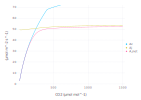

In [17]:
visualize(ModelC4BB, :CO2, [:Ac, :Aj, :A_net];
    config = ge_base,
    xstep = co2_xstep,
    ylim = (0,70),
    kind = :line,
)

#### Light response

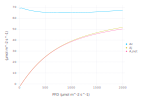

In [18]:
visualize(ModelC4BB, :PFD, [:Ac, :Aj, :A_net];
    config = ge_base,
    xstep = pfd_xstep,
    ylim = (0,70),
    kind = :line,
)

#### Temperature response

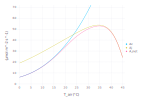

In [19]:
visualize(ModelC4BB, :T_air, [:Ac, :Aj, :A_net];
    config = ge_base,
    xstep = ta_xstep,
    ylim = (0,70),
    kind = :line,
)

#### Transition smoothing factor ($\beta$)

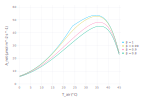

In [20]:
let S = ModelC4BB, x = :T_air, y = :A_net, c = ge_base, xstep = ta_xstep, ylim = (0,60), kind = :line
    p = visualize(S, x, y; xstep, ylim, kind, name = "β = 1", config = (c, :0 => :β => 1))
    p = visualize!(p, S, x, y; xstep, kind, name = "β = 0.99", config = (c, :0 => :β => 0.99))
    p = visualize!(p, S, x, y; xstep, kind, name = "β = 0.9", config = (c, :0 => :β => 0.9))
    p = visualize!(p, S, x, y; xstep, kind, name = "β = 0.8", config = (c, :0 => :β => 0.8))
end

In [21]:
manipulate(ModelC4BB, :T_air, :A_net;
    parameters = :0 => :β => 0.01:0.01:1,
    config = ge_base,
    xstep = ta_xstep,
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["0"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["β"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 100, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(50), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2be848460, Task (runnable) @0x00007fd2be848460), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":

#### Ex 3.3

Explore how a rose (C3) and maize (C4) leaves would respond to a range of temperatures under the atmospheric CO2 concentrations of **250 ppm** (sub-ambient), **400 ppm** (ambient), and **1000 ppm** (elevated). Assume other environmental conditions are constant and favorable under saturating light level (PFD = 2,000 $\mathrm{\mu mol}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$).

In [22]:
co2_group = Weather => :CO2   => [1000, 400, 250];
pfd_group = Weather => :PFD   => 1800:-400:600;
ta_group  = Weather => :T_air => 40:-5:10;
rh_group  = Weather => :RH    => 80:-20:20;

#### Ex 3.3.1

Generate figures to compare C3 and C4 temperature response curves at the three CO2.

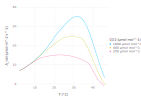

In [23]:
visualize(ModelC3BB, :T, :A_net;
    config = ge_rose,
    xstep = ta_xstep,
    group = co2_group,
    ylim = (0,40),
    kind = :line,
)

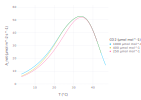

In [24]:
visualize(ModelC4BB, :T, :A_net;
    config = ge_base,
    xstep = ta_xstep,
    group = co2_group,
    ylim = (0,60),
    kind = :line,
)

#### Ex 3.3.2

Identify the **air temperature and CO2** conditions where photorespiration becomes substantial in both species, and discuss how you identified those conditions. Quick and easy way to do this is to examine the temperature response curves above to identify where the gaps are between lines.

Examine how C4 photosynthesis response to CO2 at different temperatures, and vice versa.

In [25]:
manipulate(ModelC4BB, :CO2, [:Ac, :Aj, :A_net];
    config = ge_base,
    parameters = ta_xstep,
    xstep = co2_xstep,
    xlim = (0,500),
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["T_air (°C)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 46, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(31), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2aa6f08b0, Task (runnable) @0x00007fd2aa6f08b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"for

#### Ex 3.3.3

Do the same comparisons with water-stressed C3 rose leaf at -1.5 MPa of soil water potential (or -3.0 MPa of leaf water potential). Compare their responses to fully turgid leaf with water potential close to 0 MPa.

In [26]:
manipulate(ModelC3BB, :T, :A_net;
    parameters = :StomataTuzet => :WP_leaf => -3:0.1:0,
    config = ge_rose,
    xstep = ta_xstep,
    group = co2_group,
    xlim = (0,50),
    ylim = (0,50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["StomataTuzet"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["WP_leaf"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 31, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(16), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2a6420010, Task (runnable) @0x00007fd2a6420010), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"f

In [27]:
manipulate(ModelC4BB, :T, :A_net;
    parameters = :StomataTuzet => :WP_leaf => -3:0.1:0,
    config = ge_base,
    xstep = ta_xstep,
    group = co2_group,
    xlim = (0,50),
    ylim = (0,60),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["StomataTuzet"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["WP_leaf"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 31, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(16), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2a646bc70, Task (runnable) @0x00007fd2a646bc70), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"f

## 3. A-Ci response curve

In [28]:
# Examine the relationship between supply and demand functions of photosynthesis
import Cropbox.Gadfly as G
visualize_ACi(S, targets = [:A_net], Ca = nothing;
    config = (),
    xstep = :Weather => :CO2 => 50:50:1500,
    kw...
) = begin
    c = @config(config)
    R = simulate(S; target = [:Ci, :Ca, :CO2, :gs, targets...], configs = @config(c + !xstep))
    p = plot(R, :Ci, targets; kind = :line, kw...)
    for r in eachrow(deunitfy.(R))
        x1, y1 = r.Ci, r.A_net
        x2, y2 = r.Ca, 0
        m = (y2 - y1) / (x2 - x1)
        f = x -> m * (x - x1) + y1
        if isequal(r.CO2, Cropbox.option(c, :Plot, :CO2))
            theme = G.Theme(default_color = "gray", line_style = [:solid])
            info = "An = $(round(r.A_net, digits=1)) μmol/m^2/s\ngs = $(round(r.gs, digits=3)) mol/m^2/s/bar"
            guide = G.Guide.annotation(
                G.compose(
                    G.context(),
                    G.Compose.text((x1+x2)/2 + 20, (y1+y2)/2, info),
                    G.fontsize(theme.minor_label_font_size),
                )
            )
            G.push!(p[], guide)
        else
            theme = G.Theme(default_color = "lightgray", line_style = [:dot])
        end
        l = G.layer(f, x1, x2, theme)
        G.push!(p[], l)
    end
    p
end

visualize_ACi (generic function with 3 methods)

In [29]:
manipulate(config = ge_rose, parameters = (
    :StomataTuzet => :WP_leaf => -3:0.1:0,
    :Weather      => :PFD     => 0:100:2000,
    :Weather      => :T_air   => 0:1:50,
    :Plot         => :CO2     => 50:50:1500,
)) do c
    visualize_ACi(LeafGasExchange.ModelC3BB, [:Ac, :Aj, :Ap, :A_net];
        config = c,
        xstep = :Weather => :CO2 => 50:50:1500,
        xlim = (0, 1500),
        ylim = (0, 40),
    )
end

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["StomataTuzet"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["WP_leaf"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 31, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(16), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2a64a29c0, Task (runnable) @0x00007fd2a64a29c0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"f

## 4. Canopy gas-exchange responses

For the following exercises, we're going to use gas-exchange model scaled to canopy level. Canopy-level models are named with suffix `C`. For example, `ModelC3BBC` is canopy-level C3 gas-exchange model coupled with Ball-Berry stomatal conductance model. We will be working with a rose canopy.

In [30]:
using LeafGasExchange: C3, Sun, Canopy, Radiation, LeafAngle

In [31]:
ge_canopy = @config(
    ge_rose,
    C3 => (;
        Vcm25 = 102.4,
        Jm25 = 162.0,
    ),
    Sun => (;
        day = 100,
        hour = 12,
    ),
    Canopy => (;
        LAI = 5,
    ),
    Radiation => (;
        leaf_angle_factor = 3,
        leaf_angle = LeafGasExchange.spherical,
    )
)

Vcm25,=,102.4 μmol m^-2 s^-1
Jm25,=,162.0 μmol m^-2 s^-1
Tp25,=,11.55
Rd25,=,1.26
Kc25,=,404
Ko25,=,248
Eac,=,59.4
Eao,=,36.0
Ear,=,66.4
EaVc,=,45.5
Eaj,=,43.3


In [32]:
instances(LeafAngle)

(LeafGasExchange.spherical, LeafGasExchange.horizontal, LeafGasExchange.vertical, LeafGasExchange.diaheliotropic, LeafGasExchange.empirical, LeafGasExchange.ellipsoidal)

In [33]:
manipulate(ModelC3BBC, "weather.CO2", [:A_net, "sunlit_gasexchange.A_net", "shaded_gasexchange.A_net"];
    config = ge_canopy,
    parameters = (
        Canopy => :LAI => 0:0.1:20,
        Radiation => :leaf_angle => LeafAngle,
    ),
    xstep = co2_xstep,
    ylim = (0,70),
    kind = :line,
    xlab = "CO2",
    ylab = "A_net",
    names = ["Total", "Sunlit", "Shaded"],
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Canopy"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["LAI"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(51), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd31b663b00, Task (runnable) @0x00007fd31b663b00), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_

#### Ex 3.4

Test the hypothesis that a greater leaf area in a crop canopy will result in greater productivity of the crop. Discuss the modeling outcome and whether you accept or reject the hypothesis and why.

In [34]:
manipulate(ModelC3BBC, :LAI, :A_net;
    config = ge_canopy,
    parameters = (
        Radiation => :leaf_angle => LeafAngle,
    ),
    xstep = :0 => :LAI => 0:20,
    ylim = (0,70),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Radiation"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["leaf_angle", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :select), Any[], Dict{Symbol, Any}(:attributes => Dict{Union{String, Symbol}, Any}(Symbol("data-bind") => "options : options_js, value : index, optionsText: 'key', optionsValue: 'val', valueAllowUnset: true, optionsAfterRender: disablePlaceholder")))], Dict{Symbol, Any}(:className => "select ", :style => Dict("margin" => "-5px 0 0 20px")))], Dict{Symbol, Any}(:style => Dict{String, Any}("padding" => "5px 10px 20px", "color" => :royalblue, "font-family" => "monospace"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("options_js" => (Observable(OrderedCollections.OrderedDict[OrderedCollections.OrderedDict{String, Any}("key" => "spherical", "val" => 1, "id" => "idGSSHnTuu"), OrderedCollections.OrderedDict{String, Any}("key" => "horizontal", "val" => 2, "id" => "idSLpJEcwU"), OrderedCollections.OrderedDict{String, Any}("key" => "vertical", "val" => 3, "id" => "iduIGzxYMv"), OrderedCollections.OrderedDict{String, Any}("key" => "diaheliotropic", "val" => 4, "id" => "idVDGv2rkA"), OrderedCollections.OrderedDict{String, Any}("key" => "empirical", "val" => 5, "id" => "idLyMl8uT3"), OrderedCollections.OrderedDict{String, Any}("key" => "ellipsoidal", "val" => 6, "id" => "idutmULacx")]), nothing), "index" => (Observable{Any}(1), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("options_js" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"options_js\"]()) ? (this.valueFromJulia[\"options_js\"]=true, this.model[\"options_js\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2a4f1c180, Task (runnable) @0x00007fd2a4f1c180), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n

#### Ex 3.5

Test the hypothesis if a crop canopy will be more productive to fix CO2 on a cloudy day or sunny day if the light intensity is the same. Test it with model and explain why.

In [35]:
manipulate(ModelC3BBC, "weather.CO2", :A_net;
    config = ge_canopy,
    parameters = (
        Sun => :τ => 0:0.01:1,
        Canopy => :LAI => 0:0.1:20,
    ),
    xstep = Weather => :CO2 => 10:10:800,
    ylim = (0,70),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Sun"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["τ"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(51), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2a6477540, Task (runnable) @0x00007fd2a6477540), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\

In [36]:
manipulate(ModelC3BBC, "weather.CO2", :A_net;
    config = ge_canopy,
    parameters = (
        Canopy => :LAI => 0:0.1:20,
        Weather => :PFD => 0:10:2000,
        Sun => :day => 1:365,
    ),
    xstep = Weather => :CO2 => 10:10:800,
    group = Sun => :τ => [0.3, 0.7],
    ylim = (0,100),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Canopy"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["LAI"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(51), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2a6f392c0, Task (runnable) @0x00007fd2a6f392c0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_

#### Ex 3.6

Test if improving leaf photosynthetic capacity by engineering Rubisco will be an effective adaptive breeding strategy for a plant of your choice for the future climate with rising temperature and CO2.

In [37]:
using LeafGasExchange: C3

In [38]:
manipulate(ModelC3BBC, "weather.CO2", :A_net;
    config = ge_canopy,
    parameters = (
        C3 => :Vcm25 => 10:5.0:200,
        Canopy => :LAI => 0:0.1:20,
    ),
    xstep = Weather => :CO2 => 10:10:1000,
    ylim = (0,80),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["C3"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Vcm25 (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 39, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(20), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2a6476f80, Task (runnable) @0x00007fd2a6476f80), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data =

In [39]:
manipulate(ModelC3BBC, "weather.T_air", :A_net;
    config = ge_canopy,
    parameters = (
        C3 => :Vcm25 => 10:5.0:200,
        Canopy => :LAI => 0:0.1:20,
    ),
    xstep = Weather => :T_air => 0:45,
    ylim = (0,80),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["C3"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Vcm25 (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 39, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(20), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2a6477de0, Task (runnable) @0x00007fd2a6477de0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data =

For comparsion, here are the results from leaf-level gas-exchange model for rose leaves with no scaling.

In [40]:
manipulate(ModelC3BB, :CO2, [:Ac, :Aj, :Ap, :A_net];
    config = ge_rose,
    parameters = (
        C3 => (;
            Vcm25 = 10:5.0:200,
            Jm25 = 10:5.0:300,
        ),
    ),
    xstep = Weather => :CO2 => 10:10:1000,
    ylim = (0,80),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["C3"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Vcm25 (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 39, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(20), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2a6474fe0, Task (runnable) @0x00007fd2a6474fe0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data =

In [41]:
manipulate(ModelC3BB, :T_air, [:Ac, :Aj, :Ap, :A_net];
    config = ge_rose,
    parameters = (
        C3 => (;
            Vcm25 = 10:1.0:200,
            Jm25 = 10:300,
        ),
    ),
    xstep = Weather => :T_air => 0:45,
    ylim = (0,80),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["C3"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :rebeccapurple, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["Vcm25 (μmol m^-2 s^-1)"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 191, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable{Any}(94), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/Qhvxg/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007fd2bed4f540, Task (runnable) @0x00007fd2bed4f540), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data 